## **Install**

In [1]:
!pip install numpy==1.26.0
!pip install pandas==2.2.1
!pip install seaborn==0.13.2
!pip install matplotlib==3.8.3
!pip install scikit-learn==1.4.1.post1
!pip install category_encoders

## **Import**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
import category_encoders as ce
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import pickle

## **Used Functions**

In [2]:
#Write here your function with comments


# Outlier detection function using IQR method
def detect_outliers_iqr(df):
    outliers_indices = {}  
    for col in df.columns:  
        Q1 = df[col].quantile(0.25)  
        Q3 = df[col].quantile(0.75)  
        IQR = Q3 - Q1  
        lower_bound = Q1 - 1.5 * IQR  
        upper_bound = Q3 + 1.5 * IQR  
        outliers_indices[col] = df.index[(df[col] < lower_bound) | (df[col] > upper_bound)].tolist()
    return outliers_indices  
# Function to remove outliers based on mean and standard deviation per location
def remove_pps_outliers(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('cityname', observed=False):  # Explicitly set observed=False
        m = np.mean(subdf.price_per_sqft)
        st = np.std(subdf.price_per_sqft)
        reduced_df = subdf[(subdf.price_per_sqft > (m - st)) & (subdf.price_per_sqft <= (m + st))]
        df_out = pd.concat([df_out, reduced_df], ignore_index=True)
    return df_out

## **Data**

### **Data Read**

In [3]:
# Read the CSV file into a DataFrame
data = pd.read_csv("ApartmentRentPrediction.csv")

# Take a sample from the DataFrame
sample = data.sample(n=1000)  

# Remove the sampled rows from the original DataFrame
data = data.drop(sample.index)


### **Data Header**

In [4]:
data.head(5)

,id,category,title,body,amenities,bathrooms,bedrooms,currency,fee,has_photo,...,price_display,price_type,square_feet,address,cityname,state,latitude,longitude,source,time
0,5508832632,housing/rent/apartment,"Two BR - $1,194/mo - Apartment - come and see ...","Come experience. in Cary, NC offering recently...","Clubhouse,Fireplace,Gym,Patio/Deck,Playground,...",2.5,2.0,USD,No,Thumbnail,...,"$1,194",Monthly,800,NaN,Cary,NC,35.7585,-78.7783,RentDigs.com,1568755960
1,5664576849,housing/rent/apartment,One BR 640 West Wilson Street,This unit is located at 640 West Wilson Street...,"Cable or Satellite,Dishwasher,Elevator,Garbage...",1.0,1.0,USD,No,Thumbnail,...,"$1,370",Monthly,795,640 West Wilson St,Madison,WI,43.0724,-89.4003,RentLingo,1577015508
2,5668619365,housing/rent/apartment,One BR 2777 Sw Archer Rd,"This unit is located at 2777 Sw Archer Rd, Gai...","Basketball,Cable or Satellite,Dishwasher,Inter...",1.0,1.0,USD,No,Thumbnail,...,"$1,009",Monthly,560,2777 SW Archer Road,Gainesville,FL,29.6533,-82.3656,RentLingo,1577358921
4,5668637441,housing/rent/apartment,Three BR 2216 S Palm Grove Ave,"This unit is located at 2216 S Palm Grove Ave,...",NaN,3.0,3.0,USD,No,Thumbnail,...,"$3,695",Monthly,1600,2216 S Palm Grove Avenue,Los Angeles,CA,34.0372,-118.2972,RentLingo,1577360159
5,5664597879,housing/rent/apartment,Three BR 680 Bromley Dr.,"This unit is located at 680 Bromley Dr., Baton...",NaN,2.0,3.0,USD,No,Thumbnail,...,"$1,750",Monthly,2300,680 Bromley Drive,Baton Rouge,LA,30.4415,-91.1012,RentLingo,1577017123


### **Data Describe**

In [5]:
data.describe()

,id,bathrooms,bedrooms,price,square_feet,latitude,longitude,time
count,8.000000e+03,7974.000000,7993.000000,8000.000000,8000.000000,7995.000000,7995.000000,8.000000e+03
mean,5.623663e+09,1.380612,1.744902,1485.092750,946.985375,37.666981,-94.813625,1.574906e+09
std,7.007206e+07,0.616096,0.940740,1096.102362,685.349931,5.503835,15.782619,3.754970e+06
min,5.508654e+09,1.000000,0.000000,200.000000,106.000000,21.315500,-157.930500,1.568744e+09
25%,5.509249e+09,1.000000,1.000000,949.750000,648.000000,33.640550,-101.858700,1.568781e+09
50%,5.668610e+09,1.000000,2.000000,1275.000000,803.500000,38.741800,-93.759700,1.577358e+09
75%,5.668626e+09,2.000000,2.000000,1695.000000,1100.000000,41.349650,-82.479200,1.577359e+09
max,5.668663e+09,8.500000,9.000000,52500.000000,40000.000000,61.594000,-70.191600,1.577362e+09


### **Data Info**

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8000 entries, 0 to 8999
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             8000 non-null   int64  
 1   category       8000 non-null   object 
 2   title          8000 non-null   object 
 3   body           8000 non-null   object 
 4   amenities      5184 non-null   object 
 5   bathrooms      7974 non-null   float64
 6   bedrooms       7993 non-null   float64
 7   currency       8000 non-null   object 
 8   fee            8000 non-null   object 
 9   has_photo      8000 non-null   object 
 10  pets_allowed   4685 non-null   object 
 11  price          8000 non-null   int64  
 12  price_display  8000 non-null   object 
 13  price_type     8000 non-null   object 
 14  square_feet    8000 non-null   int64  
 15  address        5353 non-null   object 
 16  cityname       7940 non-null   object 
 17  state          7940 non-null   object 
 18  latitude     

### **Data Nulls**

In [7]:
data.isna().sum()

id                  0
category            0
title               0
body                0
amenities        2816
bathrooms          26
bedrooms            7
currency            0
fee                 0
has_photo           0
pets_allowed     3315
price               0
price_display       0
price_type          0
square_feet         0
address          2647
cityname           60
state              60
latitude            5
longitude           5
source              0
time                0
dtype: int64

## **Phase One**

### **Fill Nulls**

In [8]:
# Data to work on
null_data=data.copy()

In [9]:
# Removing the null rows of cityname and latitude
null_data=null_data.dropna(axis=0,subset=["cityname","latitude","bathrooms","bedrooms"])

In [10]:
null_data["bedrooms"]=null_data["bedrooms"].astype("int")

In [11]:
# Filling nulls of pets_allowed coloumn to no
pets_allowed_fill_data = null_data.dropna(subset =["pets_allowed"],axis =0)
null_data["pets_allowed"]=null_data["pets_allowed"].fillna(pets_allowed_fill_data["pets_allowed"].mode()[0])
null_data["pets_allowed"]=null_data["pets_allowed"].astype("category")

In [12]:
address_fill_data = null_data.dropna(subset =["address"],axis =0)
null_data["address"]=null_data["address"].fillna(address_fill_data["address"].mode()[0])

In [13]:
null_data["pets_allowed"].value_counts()

pets_allowed
Cats,Dogs    7423
Cats          381
Dogs          104
Name: count, dtype: int64

In [14]:
null_data["amenities"]=null_data["amenities"].fillna(null_data["amenities"].mode()[0])


In [15]:
null_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7908 entries, 0 to 8999
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   id             7908 non-null   int64   
 1   category       7908 non-null   object  
 2   title          7908 non-null   object  
 3   body           7908 non-null   object  
 4   amenities      7908 non-null   object  
 5   bathrooms      7908 non-null   float64 
 6   bedrooms       7908 non-null   int32   
 7   currency       7908 non-null   object  
 8   fee            7908 non-null   object  
 9   has_photo      7908 non-null   object  
 10  pets_allowed   7908 non-null   category
 11  price          7908 non-null   int64   
 12  price_display  7908 non-null   object  
 13  price_type     7908 non-null   object  
 14  square_feet    7908 non-null   int64   
 15  address        7908 non-null   object  
 16  cityname       7908 non-null   object  
 17  state          7908 non-null   object 

In [16]:
null_data.isna().sum()

id               0
category         0
title            0
body             0
amenities        0
bathrooms        0
bedrooms         0
currency         0
fee              0
has_photo        0
pets_allowed     0
price            0
price_display    0
price_type       0
square_feet      0
address          0
cityname         0
state            0
latitude         0
longitude        0
source           0
time             0
dtype: int64

In [190]:
no_nulls_in_amenities = null_data.copy()
clone=no_nulls_in_amenities.copy()
no_nulls_in_amenities = no_nulls_in_amenities["amenities"].str.split(",")
no_nulls_in_amenities

0       [Clubhouse, Fireplace, Gym, Patio/Deck, Playgr...
1       [Cable or Satellite, Dishwasher, Elevator, Gar...
2       [Basketball, Cable or Satellite, Dishwasher, I...
4                                               [Parking]
5                                               [Parking]
                              ...                        
8993                                            [Parking]
8994             [Clubhouse, Gym, Parking, Pool, Storage]
8996                                            [Parking]
8997                                   [Parking, Storage]
8999                                            [Parking]
Name: amenities, Length: 7908, dtype: object

In [ ]:
no_nulls_in_amenities=no_nulls_in_amenities.reset_index()

In [18]:
no_nulls_in_amenities

,index,amenities
0,0,"[Clubhouse, Fireplace, Gym, Patio/Deck, Playgr..."
1,1,"[Cable or Satellite, Dishwasher, Elevator, Gar..."
2,2,"[Basketball, Cable or Satellite, Dishwasher, I..."
3,4,[Parking]
4,5,[Parking]
...,...,...
7903,8993,[Parking]
7904,8994,"[Clubhouse, Gym, Parking, Pool, Storage]"
7905,8996,[Parking]
7906,8997,"[Parking, Storage]"


In [19]:
li=[]
for x in range(len(no_nulls_in_amenities)) :
    li+=no_nulls_in_amenities.iloc[x]["amenities"]

In [20]:
li

['Clubhouse',
 'Fireplace',
 'Gym',
 'Patio/Deck',
 'Playground',
 'Pool',
 'Cable or Satellite',
 'Dishwasher',
 'Elevator',
 'Garbage Disposal',
 'Internet Access',
 'Parking',
 'Patio/Deck',
 'Refrigerator',
 'Storage',
 'Basketball',
 'Cable or Satellite',
 'Dishwasher',
 'Internet Access',
 'Patio/Deck',
 'Refrigerator',
 'Tennis',
 'Parking',
 'Parking',
 'Gym',
 'Pool',
 'Parking',
 'Cable or Satellite',
 'Dishwasher',
 'Elevator',
 'Internet Access',
 'Parking',
 'Patio/Deck',
 'Playground',
 'Refrigerator',
 'Storage',
 'Wood Floors',
 'Dishwasher',
 'Parking',
 'Pool',
 'Refrigerator',
 'Gated',
 'Pool',
 'TV',
 'Dishwasher',
 'Internet Access',
 'Parking',
 'Pool',
 'Refrigerator',
 'AC',
 'Clubhouse',
 'Parking',
 'Playground',
 'Pool',
 'Dishwasher',
 'Parking',
 'Patio/Deck',
 'Refrigerator',
 'Parking',
 'Parking',
 'Patio/Deck',
 'Pool',
 'Tennis',
 'Parking',
 'Refrigerator',
 'Parking',
 'Parking',
 'Parking',
 'Parking',
 'Parking',
 'Cable or Satellite',
 'Dishwashe

In [21]:
li=set(li)

In [22]:
li

{'AC',
 'Alarm',
 'Basketball',
 'Cable or Satellite',
 'Clubhouse',
 'Dishwasher',
 'Doorman',
 'Elevator',
 'Fireplace',
 'Garbage Disposal',
 'Gated',
 'Golf',
 'Gym',
 'Hot Tub',
 'Internet Access',
 'Luxury',
 'Parking',
 'Patio/Deck',
 'Playground',
 'Pool',
 'Refrigerator',
 'Storage',
 'TV',
 'Tennis',
 'View',
 'Washer Dryer',
 'Wood Floors'}

In [23]:
clone=clone.reset_index()

In [24]:
#Make new columns with boolians
for c in li :
    clone[c]=0
    clone[c]=clone[c].astype("int")

In [25]:
clone

,index,id,category,title,body,amenities,bathrooms,bedrooms,currency,fee,...,AC,Wood Floors,Pool,Internet Access,TV,Playground,Tennis,Clubhouse,Elevator,Patio/Deck
0,0,5508832632,housing/rent/apartment,"Two BR - $1,194/mo - Apartment - come and see ...","Come experience. in Cary, NC offering recently...","Clubhouse,Fireplace,Gym,Patio/Deck,Playground,...",2.5,2,USD,No,...,0,0,0,0,0,0,0,0,0,0
1,1,5664576849,housing/rent/apartment,One BR 640 West Wilson Street,This unit is located at 640 West Wilson Street...,"Cable or Satellite,Dishwasher,Elevator,Garbage...",1.0,1,USD,No,...,0,0,0,0,0,0,0,0,0,0
2,2,5668619365,housing/rent/apartment,One BR 2777 Sw Archer Rd,"This unit is located at 2777 Sw Archer Rd, Gai...","Basketball,Cable or Satellite,Dishwasher,Inter...",1.0,1,USD,No,...,0,0,0,0,0,0,0,0,0,0
3,4,5668637441,housing/rent/apartment,Three BR 2216 S Palm Grove Ave,"This unit is located at 2216 S Palm Grove Ave,...",Parking,3.0,3,USD,No,...,0,0,0,0,0,0,0,0,0,0
4,5,5664597879,housing/rent/apartment,Three BR 680 Bromley Dr.,"This unit is located at 680 Bromley Dr., Baton...",Parking,2.0,3,USD,No,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7903,8993,5668633427,housing/rent/apartment,Studio apartment 1136 South 29th Street,This unit is located at 1136 South 29th Street...,Parking,1.0,0,USD,No,...,0,0,0,0,0,0,0,0,0,0
7904,8994,5509155244,housing/rent/apartment,Two BR - 932 sq. ft. - in a great area.,"Square footage: 932 square feet, unit number: ...","Clubhouse,Gym,Parking,Pool,Storage",2.0,2,USD,No,...,0,0,0,0,0,0,0,0,0,0
7905,8996,5668612787,housing/rent/apartment,One BR 10001 Ne 1st St,"This unit is located at 10001 Ne first St, Bel...",Parking,1.0,1,USD,No,...,0,0,0,0,0,0,0,0,0,0
7906,8997,5668617853,housing/rent/apartment,Two BR 95 E 2nd St,"This unit is located at 95 E second St, Fond D...","Parking,Storage",1.0,2,USD,No,...,0,0,0,0,0,0,0,0,0,0


In [26]:
#fill the columns with one
for new in range(len(clone)) :
    for col in li :
        if col in no_nulls_in_amenities.iloc[new]["amenities"] :
            clone.at[new,col]=1
            

In [27]:
clone

,index,id,category,title,body,amenities,bathrooms,bedrooms,currency,fee,...,AC,Wood Floors,Pool,Internet Access,TV,Playground,Tennis,Clubhouse,Elevator,Patio/Deck
0,0,5508832632,housing/rent/apartment,"Two BR - $1,194/mo - Apartment - come and see ...","Come experience. in Cary, NC offering recently...","Clubhouse,Fireplace,Gym,Patio/Deck,Playground,...",2.5,2,USD,No,...,0,0,1,0,0,1,0,1,0,1
1,1,5664576849,housing/rent/apartment,One BR 640 West Wilson Street,This unit is located at 640 West Wilson Street...,"Cable or Satellite,Dishwasher,Elevator,Garbage...",1.0,1,USD,No,...,0,0,0,1,0,0,0,0,1,1
2,2,5668619365,housing/rent/apartment,One BR 2777 Sw Archer Rd,"This unit is located at 2777 Sw Archer Rd, Gai...","Basketball,Cable or Satellite,Dishwasher,Inter...",1.0,1,USD,No,...,0,0,0,1,0,0,1,0,0,1
3,4,5668637441,housing/rent/apartment,Three BR 2216 S Palm Grove Ave,"This unit is located at 2216 S Palm Grove Ave,...",Parking,3.0,3,USD,No,...,0,0,0,0,0,0,0,0,0,0
4,5,5664597879,housing/rent/apartment,Three BR 680 Bromley Dr.,"This unit is located at 680 Bromley Dr., Baton...",Parking,2.0,3,USD,No,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7903,8993,5668633427,housing/rent/apartment,Studio apartment 1136 South 29th Street,This unit is located at 1136 South 29th Street...,Parking,1.0,0,USD,No,...,0,0,0,0,0,0,0,0,0,0
7904,8994,5509155244,housing/rent/apartment,Two BR - 932 sq. ft. - in a great area.,"Square footage: 932 square feet, unit number: ...","Clubhouse,Gym,Parking,Pool,Storage",2.0,2,USD,No,...,0,0,1,0,0,0,0,1,0,0
7905,8996,5668612787,housing/rent/apartment,One BR 10001 Ne 1st St,"This unit is located at 10001 Ne first St, Bel...",Parking,1.0,1,USD,No,...,0,0,0,0,0,0,0,0,0,0
7906,8997,5668617853,housing/rent/apartment,Two BR 95 E 2nd St,"This unit is located at 95 E second St, Fond D...","Parking,Storage",1.0,2,USD,No,...,0,0,0,0,0,0,0,0,0,0


In [28]:
clone["cityname"]=clone["cityname"].astype("category")

In [29]:
clone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7908 entries, 0 to 7907
Data columns (total 50 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   index               7908 non-null   int64   
 1   id                  7908 non-null   int64   
 2   category            7908 non-null   object  
 3   title               7908 non-null   object  
 4   body                7908 non-null   object  
 5   amenities           7908 non-null   object  
 6   bathrooms           7908 non-null   float64 
 7   bedrooms            7908 non-null   int32   
 8   currency            7908 non-null   object  
 9   fee                 7908 non-null   object  
 10  has_photo           7908 non-null   object  
 11  pets_allowed        7908 non-null   category
 12  price               7908 non-null   int64   
 13  price_display       7908 non-null   object  
 14  price_type          7908 non-null   object  
 15  square_feet         7908 non-null   in

In [30]:
no_null_data=clone.copy()

In [31]:
no_null_data["sum_of_items"]=0

In [32]:
for index in range(len(no_null_data)):
    sum_of_items = 0  
    for item in li:
        sum_of_items += no_null_data.loc[index, item]  
    no_null_data.loc[index, "sum_of_items"] = sum_of_items  


In [33]:
no_null_data

,index,id,category,title,body,amenities,bathrooms,bedrooms,currency,fee,...,Wood Floors,Pool,Internet Access,TV,Playground,Tennis,Clubhouse,Elevator,Patio/Deck,sum_of_items
0,0,5508832632,housing/rent/apartment,"Two BR - $1,194/mo - Apartment - come and see ...","Come experience. in Cary, NC offering recently...","Clubhouse,Fireplace,Gym,Patio/Deck,Playground,...",2.5,2,USD,No,...,0,1,0,0,1,0,1,0,1,6
1,1,5664576849,housing/rent/apartment,One BR 640 West Wilson Street,This unit is located at 640 West Wilson Street...,"Cable or Satellite,Dishwasher,Elevator,Garbage...",1.0,1,USD,No,...,0,0,1,0,0,0,0,1,1,9
2,2,5668619365,housing/rent/apartment,One BR 2777 Sw Archer Rd,"This unit is located at 2777 Sw Archer Rd, Gai...","Basketball,Cable or Satellite,Dishwasher,Inter...",1.0,1,USD,No,...,0,0,1,0,0,1,0,0,1,7
3,4,5668637441,housing/rent/apartment,Three BR 2216 S Palm Grove Ave,"This unit is located at 2216 S Palm Grove Ave,...",Parking,3.0,3,USD,No,...,0,0,0,0,0,0,0,0,0,1
4,5,5664597879,housing/rent/apartment,Three BR 680 Bromley Dr.,"This unit is located at 680 Bromley Dr., Baton...",Parking,2.0,3,USD,No,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7903,8993,5668633427,housing/rent/apartment,Studio apartment 1136 South 29th Street,This unit is located at 1136 South 29th Street...,Parking,1.0,0,USD,No,...,0,0,0,0,0,0,0,0,0,1
7904,8994,5509155244,housing/rent/apartment,Two BR - 932 sq. ft. - in a great area.,"Square footage: 932 square feet, unit number: ...","Clubhouse,Gym,Parking,Pool,Storage",2.0,2,USD,No,...,0,1,0,0,0,0,1,0,0,5
7905,8996,5668612787,housing/rent/apartment,One BR 10001 Ne 1st St,"This unit is located at 10001 Ne first St, Bel...",Parking,1.0,1,USD,No,...,0,0,0,0,0,0,0,0,0,1
7906,8997,5668617853,housing/rent/apartment,Two BR 95 E 2nd St,"This unit is located at 95 E second St, Fond D...","Parking,Storage",1.0,2,USD,No,...,0,0,0,0,0,0,0,0,0,2


In [34]:
no_null_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7908 entries, 0 to 7907
Data columns (total 51 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   index               7908 non-null   int64   
 1   id                  7908 non-null   int64   
 2   category            7908 non-null   object  
 3   title               7908 non-null   object  
 4   body                7908 non-null   object  
 5   amenities           7908 non-null   object  
 6   bathrooms           7908 non-null   float64 
 7   bedrooms            7908 non-null   int32   
 8   currency            7908 non-null   object  
 9   fee                 7908 non-null   object  
 10  has_photo           7908 non-null   object  
 11  pets_allowed        7908 non-null   category
 12  price               7908 non-null   int64   
 13  price_display       7908 non-null   object  
 14  price_type          7908 non-null   object  
 15  square_feet         7908 non-null   in

In [35]:
no_null_data.isna().sum()

index                 0
id                    0
category              0
title                 0
body                  0
amenities             0
bathrooms             0
bedrooms              0
currency              0
fee                   0
has_photo             0
pets_allowed          0
price                 0
price_display         0
price_type            0
square_feet           0
address               0
cityname              0
state                 0
latitude              0
longitude             0
source                0
time                  0
Storage               0
Dishwasher            0
Golf                  0
Luxury                0
Parking               0
Doorman               0
Gated                 0
Gym                   0
Fireplace             0
View                  0
Alarm                 0
Refrigerator          0
Basketball            0
Washer Dryer          0
Garbage Disposal      0
Cable or Satellite    0
Hot Tub               0
AC                    0
Wood Floors     

### **Datatype Check**

In [36]:
DataCheck = no_null_data.copy()

In [37]:
DataCheck.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7908 entries, 0 to 7907
Data columns (total 51 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   index               7908 non-null   int64   
 1   id                  7908 non-null   int64   
 2   category            7908 non-null   object  
 3   title               7908 non-null   object  
 4   body                7908 non-null   object  
 5   amenities           7908 non-null   object  
 6   bathrooms           7908 non-null   float64 
 7   bedrooms            7908 non-null   int32   
 8   currency            7908 non-null   object  
 9   fee                 7908 non-null   object  
 10  has_photo           7908 non-null   object  
 11  pets_allowed        7908 non-null   category
 12  price               7908 non-null   int64   
 13  price_display       7908 non-null   object  
 14  price_type          7908 non-null   object  
 15  square_feet         7908 non-null   in

In [38]:
DataCheck["category"]=DataCheck["category"].astype("category")

In [39]:
DataCheck["title"]=DataCheck["title"].astype("category")

In [40]:
DataCheck["body"]=DataCheck["body"].astype("category")

In [41]:
DataCheck["body"]=DataCheck["body"].astype("category")

In [42]:
DataCheck["currency"]=DataCheck["currency"].astype("category")

In [43]:
DataCheck["price_type"]=DataCheck["price_type"].astype("category")

In [44]:
DataCheck["address"]=DataCheck["address"].astype("category")

In [45]:
DataCheck["fee"]=DataCheck["fee"].astype("category")

In [46]:
DataCheck["bathrooms"]=DataCheck["bathrooms"].astype("int")

In [47]:
DataCheck["bedrooms"]=DataCheck["bedrooms"].astype("int")

In [48]:
DataCheck["has_photo"] = DataCheck["has_photo"].astype("category")

In [49]:
DataCheck["state"] = DataCheck["state"].astype("category")

In [50]:
DataCheck["source"] = DataCheck["source"].astype("category")

In [51]:
DataCheck["time"] = pd.to_datetime(DataCheck["time"])

In [52]:
DataCheck["cityname"]=DataCheck["cityname"].astype("category")

In [53]:
DataCheck["price_display"]=DataCheck["price_display"].str.replace("$","")

In [54]:
DataCheck["price_display"]=DataCheck["price_display"].str.replace(",","")

In [55]:
DataCheck["price_display"]=DataCheck["price_display"].str.replace("Weekly","")

In [56]:
DataCheck["price_display"]=DataCheck["price_display"].str.replace("Monthly","")

In [57]:
DataCheck["price_display"]=DataCheck["price_display"].str.replace("|","")

In [58]:
DataCheck["price_display"]=DataCheck["price_display"].astype("int")

In [59]:
DataCheck.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7908 entries, 0 to 7907
Data columns (total 51 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   index               7908 non-null   int64         
 1   id                  7908 non-null   int64         
 2   category            7908 non-null   category      
 3   title               7908 non-null   category      
 4   body                7908 non-null   category      
 5   amenities           7908 non-null   object        
 6   bathrooms           7908 non-null   int32         
 7   bedrooms            7908 non-null   int32         
 8   currency            7908 non-null   category      
 9   fee                 7908 non-null   category      
 10  has_photo           7908 non-null   category      
 11  pets_allowed        7908 non-null   category      
 12  price               7908 non-null   int64         
 13  price_display       7908 non-null   int32       

### **Wrong Values**

In [60]:
wrong_values = DataCheck.copy() 

In [61]:
wrong_values["has_photo"].value_counts()

has_photo
Thumbnail    7040
Yes           735
No            133
Name: count, dtype: int64

In [62]:
wrong_values['bedrooms']=wrong_values['bedrooms'].apply(np.floor).astype(float)
wrong_values['bathrooms'] = wrong_values['bathrooms'].apply(np.floor).astype(float)
wrong_values.loc[wrong_values["has_photo"] == "Thumbnail", "has_photo"] = "Yes"

In [63]:
city = wrong_values["cityname"].value_counts()

In [64]:
city

cityname
Austin          428
Dallas          171
Houston         159
San Antonio     146
Los Angeles     129
               ... 
Leonia            1
Lewes             1
Lima              1
Lincoln Park      1
Los Alamitos      1
Name: count, Length: 1419, dtype: int64

In [65]:
remove = city[city < 10].index.tolist()
citytoremove=remove

In [66]:
remove

['Shreveport',
 'Cedar Park',
 'Newport News',
 'Detroit',
 'Wichita',
 'Forest Lake',
 'Fort Lauderdale',
 'Chesapeake',
 'Flanders',
 'Davenport',
 'Sacramento',
 'Everett',
 'Medford',
 'Odenton',
 'Hampton',
 'Fort Smith',
 'Suwanee',
 'Redondo Beach',
 'Coraopolis',
 'West Hollywood',
 'Albuquerque',
 'Trenton',
 'Mount Laurel',
 'Cedar Falls',
 'Spokane',
 'Chapel Hill',
 'Grand Rapids',
 'Clarkston',
 'Tyler',
 'Hartford',
 'Corvallis',
 'Cockeysville',
 'Antioch',
 'Odessa',
 'Plano',
 'Palo Alto',
 'Bismarck',
 'Salem',
 'Longview',
 'Midland',
 'Boise',
 'Riverside',
 'Manhattan',
 'Macon',
 'Bellingham',
 'Texarkana',
 'Mebane',
 'Bradenton',
 'Sammamish',
 'Irmo',
 'Somerville',
 'Burlington',
 'Auburn',
 'Eden Prairie',
 'Torrance',
 'Chattanooga',
 'Monroe',
 'Henderson',
 'Denton',
 'Homestead',
 'North Hollywood',
 'Venice',
 'Fond Du Lac',
 'Portsmouth',
 'Franklin',
 'Loveland',
 'East Hartford',
 'Berkeley',
 'Edmonds',
 'Mountlake Terrace',
 'Ypsilanti',
 'Tempe',
 

In [67]:
wrong_values["cityname"] = wrong_values["cityname"].cat.add_categories("others")

In [68]:
wrong_values.loc[wrong_values["cityname"].isin(remove), "cityname"] = "others"

In [69]:
wrong_values["cityname"].value_counts()

cityname
others            2932
Austin             428
Dallas             171
Houston            159
San Antonio        146
                  ... 
Grand Rapids         0
Grand Prairie        0
Grand Ledge          0
Grand Junction       0
Aberdeen             0
Name: count, Length: 1420, dtype: int64

In [70]:
wrong_values["cityname"]

0               Cary
1            Madison
2             others
3        Los Angeles
4        Baton Rouge
            ...     
7903           Omaha
7904    Maple Valley
7905        Bellevue
7906          others
7907          others
Name: cityname, Length: 7908, dtype: category
Categories (1420, object): ['Aberdeen', 'Abilene', 'Abingdon', 'Abington', ..., 'Yuba City', 'Yukon', 'Zachary', 'others']

In [71]:
phaseOne_data=wrong_values.copy()

## **Phase Two**

### **New Feature**

In [72]:
new_feature_data = phaseOne_data.copy()
new_feature_data['price_per_sqft'] = new_feature_data['price_display']*100000/new_feature_data['square_feet']

### **Outliers**

In [73]:
outliersdata_1=new_feature_data.copy()

In [74]:
#outliersdata_1['price_display'] = np.log(outliersdata_1['price_display']) 

<Axes: >

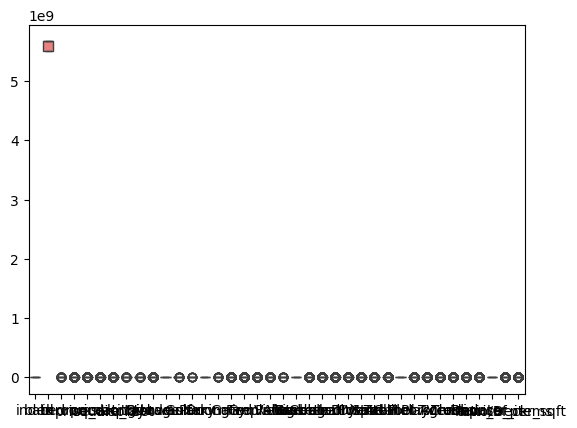

In [75]:
sns.boxplot(outliersdata_1)

In [76]:
numcoll = ["bedrooms","square_feet","bathrooms","price_display"]

In [77]:
outliersdata_1 = outliersdata_1[outliersdata_1['bedrooms'] > 0]

In [78]:
outliersdata_1 = outliersdata_1[outliersdata_1['bathrooms'] > 0]

In [79]:
#outliersdata_1 = outliersdata_1[(outliersdata_1.square_feet/outliersdata_1.bedrooms>250)]

In [80]:
outliersdata=outliersdata_1[numcoll]

<Axes: >

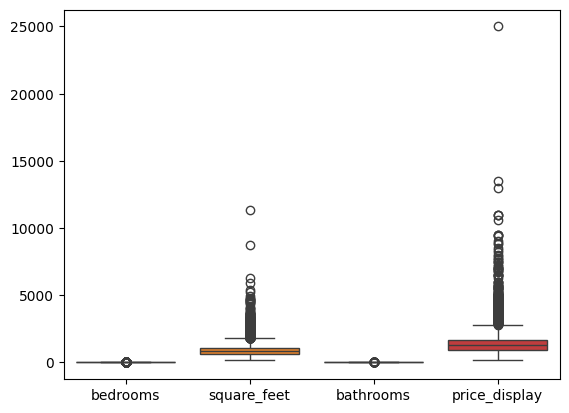

In [81]:
sns.boxplot(outliersdata)

In [82]:
theoutlierindex =detect_outliers_iqr(outliersdata)

In [83]:
theoutlierindex
for key in theoutlierindex.keys() :
    print(f"{key} the len = {len(theoutlierindex[key])}")

bedrooms the len = 409
square_feet the len = 501
bathrooms the len = 57
price_display the len = 478


In [84]:

Q3 = outliersdata["square_feet"].quantile(0.75)
Q1 = outliersdata["square_feet"].quantile(0.25)
square_feet_Q3 =Q3
square_feet_Q1 = Q1


In [85]:
outliersdata.loc[outliersdata["square_feet"] > Q3, "square_feet"] =  Q3
outliersdata.loc[outliersdata["square_feet"] < Q1, "square_feet"] =  Q1

In [86]:
Q3 = outliersdata["bedrooms"].quantile(0.75)
Q1 = outliersdata["bedrooms"].quantile(0.25)
bedrooms_Q3=Q3
bedrooms_Q1=Q1

In [87]:
outliersdata.loc[outliersdata["bedrooms"] > Q3, "bedrooms"] =  Q3
outliersdata.loc[outliersdata["bedrooms"] < Q1, "bedrooms"] =  Q1

In [88]:
Q3 = outliersdata["price_display"].quantile(0.75)
Q1 = outliersdata["price_display"].quantile(0.25)
price_Q3=Q3
price_Q1=Q1

In [89]:
outliersdata.loc[outliersdata["price_display"] > Q3, "price_display"] =  Q3
outliersdata.loc[outliersdata["price_display"] < Q1, "price_display"] =  Q1

<Axes: >

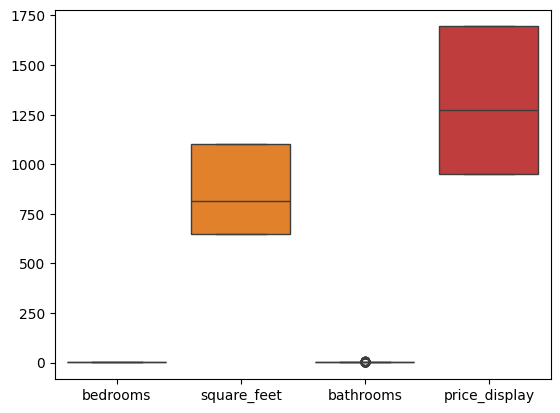

In [90]:
sns.boxplot(outliersdata)

In [91]:
outliersdata=outliersdata.drop(theoutlierindex['bathrooms'])

<Axes: >

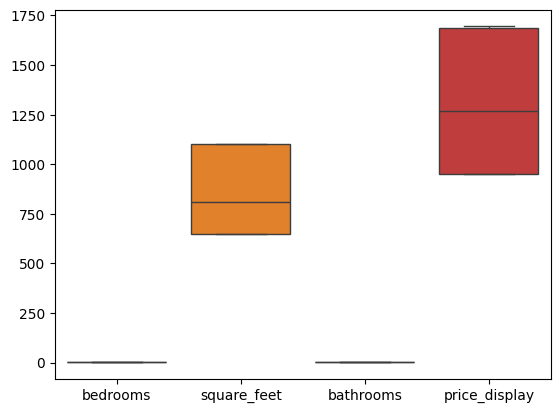

In [92]:
sns.boxplot(outliersdata)

In [93]:
outliersdata_1[numcoll]=outliersdata[numcoll]

In [94]:
outliersdata_1=outliersdata_1.dropna()

In [95]:
outliersdata_1.isna().sum()

index                 0
id                    0
category              0
title                 0
body                  0
amenities             0
bathrooms             0
bedrooms              0
currency              0
fee                   0
has_photo             0
pets_allowed          0
price                 0
price_display         0
price_type            0
square_feet           0
address               0
cityname              0
state                 0
latitude              0
longitude             0
source                0
time                  0
Storage               0
Dishwasher            0
Golf                  0
Luxury                0
Parking               0
Doorman               0
Gated                 0
Gym                   0
Fireplace             0
View                  0
Alarm                 0
Refrigerator          0
Basketball            0
Washer Dryer          0
Garbage Disposal      0
Cable or Satellite    0
Hot Tub               0
AC                    0
Wood Floors     

In [96]:
outliersdata_1["bathrooms"].value_counts()

bathrooms
1.0    5346
2.0    2175
3.0     190
Name: count, dtype: int64

### **Encoding**

In [97]:
encodingdata=outliersdata_1.copy()

In [98]:
encodingdata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7711 entries, 0 to 7907
Data columns (total 52 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   index               7711 non-null   int64         
 1   id                  7711 non-null   int64         
 2   category            7711 non-null   category      
 3   title               7711 non-null   category      
 4   body                7711 non-null   category      
 5   amenities           7711 non-null   object        
 6   bathrooms           7711 non-null   float64       
 7   bedrooms            7711 non-null   float64       
 8   currency            7711 non-null   category      
 9   fee                 7711 non-null   category      
 10  has_photo           7711 non-null   category      
 11  pets_allowed        7711 non-null   category      
 12  price               7711 non-null   int64         
 13  price_display       7711 non-null   float64       
 1

In [99]:
targetencode=["cityname","amenities","address"]

In [100]:
encoder = ce.TargetEncoder(cols=targetencode)

In [101]:
t = encoder.fit(encodingdata[targetencode], encodingdata["price_display"])

In [102]:
encodingdata[targetencode] = t.transform(encodingdata[targetencode])

In [103]:
encodingdata = pd.get_dummies(encodingdata, columns=['pets_allowed'], prefix='pets')

In [104]:
targetencode2=["category","title","body","currency","fee","has_photo","price_type","state","time","source"]

In [105]:
encoding={}
label_encoder = LabelEncoder()
for col in targetencode2:
    encoding[col] = label_encoder.fit(encodingdata[col])
    encodingdata[col] = encoding[col].transform(encodingdata[col])

In [106]:
for col in targetencode:
    encoding[col]=t

In [107]:
encoding

{'category': LabelEncoder(),
 'title': LabelEncoder(),
 'body': LabelEncoder(),
 'currency': LabelEncoder(),
 'fee': LabelEncoder(),
 'has_photo': LabelEncoder(),
 'price_type': LabelEncoder(),
 'state': LabelEncoder(),
 'time': LabelEncoder(),
 'source': LabelEncoder(),
 'cityname': TargetEncoder(cols=['cityname', 'amenities', 'address']),
 'amenities': TargetEncoder(cols=['cityname', 'amenities', 'address']),
 'address': TargetEncoder(cols=['cityname', 'amenities', 'address'])}

In [108]:
encodingdata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7711 entries, 0 to 7907
Data columns (total 54 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   index               7711 non-null   int64  
 1   id                  7711 non-null   int64  
 2   category            7711 non-null   int32  
 3   title               7711 non-null   int32  
 4   body                7711 non-null   int32  
 5   amenities           7711 non-null   float64
 6   bathrooms           7711 non-null   float64
 7   bedrooms            7711 non-null   float64
 8   currency            7711 non-null   int32  
 9   fee                 7711 non-null   int32  
 10  has_photo           7711 non-null   int32  
 11  price               7711 non-null   int64  
 12  price_display       7711 non-null   float64
 13  price_type          7711 non-null   int32  
 14  square_feet         7711 non-null   float64
 15  address             7711 non-null   float64
 16  cityname   

### **Duplicates**

In [109]:
df_no_duplicates = encodingdata.drop_duplicates()

In [110]:
df_no_duplicates.head(9000)

,index,id,category,title,body,amenities,bathrooms,bedrooms,currency,fee,...,Playground,Tennis,Clubhouse,Elevator,Patio/Deck,sum_of_items,price_per_sqft,pets_Cats,"pets_Cats,Dogs",pets_Dogs
0,0,5508832632,0,5829,293,1281.271725,2.0,2.0,0,0,...,1,0,1,0,1,6,149250.000000,False,True,False
1,1,5664576849,0,3410,6044,1309.588275,1.0,1.0,0,0,...,0,0,0,1,1,9,172327.044025,False,True,False
2,2,5668619365,0,2589,4310,1262.667070,1.0,1.0,0,0,...,0,1,0,0,1,7,180178.571429,False,True,False
3,4,5668637441,0,5329,3889,1350.564848,3.0,2.0,0,0,...,0,0,0,0,0,1,230937.500000,False,True,False
4,5,5664597879,0,5633,6129,1350.564848,2.0,2.0,0,0,...,0,0,0,0,0,1,76086.956522,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7902,8992,5668609353,0,3823,345,1303.940573,1.0,1.0,0,0,...,0,0,0,0,1,1,120915.032680,True,False,False
7904,8994,5509155244,0,5830,1868,1396.606082,2.0,2.0,0,0,...,0,0,1,0,0,5,205472.103004,False,True,False
7905,8996,5668612787,0,1511,2162,1350.564848,1.0,1.0,0,0,...,0,0,0,0,0,1,246966.019417,True,False,False
7906,8997,5668617853,0,6943,6793,1457.916749,1.0,2.0,0,0,...,0,0,0,0,0,2,50236.966825,False,True,False


### **Normalization** 

In [111]:
norm_data = df_no_duplicates.copy()

In [112]:
minmax=["square_feet"]

In [113]:
scaler = MinMaxScaler()


square_feet_scaler = scaler.fit(norm_data[['square_feet']])
norm_data['square_feet'] = square_feet_scaler.transform(norm_data[['square_feet']])

#norm_data['square_feet'] = scaler.fit_transform(norm_data[['square_feet']])

In [114]:
phaseTwo_data=norm_data.copy()

In [115]:
phaseTwo_data

,index,id,category,title,body,amenities,bathrooms,bedrooms,currency,fee,...,Playground,Tennis,Clubhouse,Elevator,Patio/Deck,sum_of_items,price_per_sqft,pets_Cats,"pets_Cats,Dogs",pets_Dogs
0,0,5508832632,0,5829,293,1281.271725,2.0,2.0,0,0,...,1,0,1,0,1,6,149250.000000,False,True,False
1,1,5664576849,0,3410,6044,1309.588275,1.0,1.0,0,0,...,0,0,0,1,1,9,172327.044025,False,True,False
2,2,5668619365,0,2589,4310,1262.667070,1.0,1.0,0,0,...,0,1,0,0,1,7,180178.571429,False,True,False
3,4,5668637441,0,5329,3889,1350.564848,3.0,2.0,0,0,...,0,0,0,0,0,1,230937.500000,False,True,False
4,5,5664597879,0,5633,6129,1350.564848,2.0,2.0,0,0,...,0,0,0,0,0,1,76086.956522,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7902,8992,5668609353,0,3823,345,1303.940573,1.0,1.0,0,0,...,0,0,0,0,1,1,120915.032680,True,False,False
7904,8994,5509155244,0,5830,1868,1396.606082,2.0,2.0,0,0,...,0,0,1,0,0,5,205472.103004,False,True,False
7905,8996,5668612787,0,1511,2162,1350.564848,1.0,1.0,0,0,...,0,0,0,0,0,1,246966.019417,True,False,False
7906,8997,5668617853,0,6943,6793,1457.916749,1.0,2.0,0,0,...,0,0,0,0,0,2,50236.966825,False,True,False


In [191]:
phaseTwo_data["square_feet"].describe()

count    7711.000000
mean        0.453951
std         0.406120
min         0.000000
25%         0.000000
50%         0.355556
75%         1.000000
max         1.000000
Name: square_feet, dtype: float64

In [117]:
phaseTwo_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7711 entries, 0 to 7907
Data columns (total 54 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   index               7711 non-null   int64  
 1   id                  7711 non-null   int64  
 2   category            7711 non-null   int32  
 3   title               7711 non-null   int32  
 4   body                7711 non-null   int32  
 5   amenities           7711 non-null   float64
 6   bathrooms           7711 non-null   float64
 7   bedrooms            7711 non-null   float64
 8   currency            7711 non-null   int32  
 9   fee                 7711 non-null   int32  
 10  has_photo           7711 non-null   int32  
 11  price               7711 non-null   int64  
 12  price_display       7711 non-null   float64
 13  price_type          7711 non-null   int32  
 14  square_feet         7711 non-null   float64
 15  address             7711 non-null   float64
 16  cityname   

In [118]:
phaseTwo_data.isna().sum()

index                 0
id                    0
category              0
title                 0
body                  0
amenities             0
bathrooms             0
bedrooms              0
currency              0
fee                   0
has_photo             0
price                 0
price_display         0
price_type            0
square_feet           0
address               0
cityname              0
state                 0
latitude              0
longitude             0
source                0
time                  0
Storage               0
Dishwasher            0
Golf                  0
Luxury                0
Parking               0
Doorman               0
Gated                 0
Gym                   0
Fireplace             0
View                  0
Alarm                 0
Refrigerator          0
Basketball            0
Washer Dryer          0
Garbage Disposal      0
Cable or Satellite    0
Hot Tub               0
AC                    0
Wood Floors           0
Pool            

## **Phase Three**

### **Correlation**

In [119]:
correlation_data=phaseTwo_data.copy()

In [120]:
correlation_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7711 entries, 0 to 7907
Data columns (total 54 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   index               7711 non-null   int64  
 1   id                  7711 non-null   int64  
 2   category            7711 non-null   int32  
 3   title               7711 non-null   int32  
 4   body                7711 non-null   int32  
 5   amenities           7711 non-null   float64
 6   bathrooms           7711 non-null   float64
 7   bedrooms            7711 non-null   float64
 8   currency            7711 non-null   int32  
 9   fee                 7711 non-null   int32  
 10  has_photo           7711 non-null   int32  
 11  price               7711 non-null   int64  
 12  price_display       7711 non-null   float64
 13  price_type          7711 non-null   int32  
 14  square_feet         7711 non-null   float64
 15  address             7711 non-null   float64
 16  cityname   

In [121]:
features = correlation_data.drop(columns=["price_display"])
transformed_data = pd.concat([features, correlation_data["price_display"]], axis=1)

In [122]:
from scipy.stats import boxcox
#transformed_data["square_feet"] = np.power(transformed_data["square_feet"],2)
transformed_data['square_feet_log'] = np.log(transformed_data['square_feet'])
transformed_data['square_feet_sqrt'] = np.sqrt(transformed_data['square_feet'])
#transformed_data['square_feet_exp'] = np.exp(transformed_data['square_feet'])




max_value = transformed_data['square_feet'].max()
min_value = transformed_data['square_feet'].min()

if max_value > 709:  # Maximum value for safe exponentiation in numpy
    transformed_data['square_feet'] = transformed_data['square_feet'].apply(lambda x: 709 if x > 709 else x)
if min_value < -709:  # Minimum value for safe exponentiation in numpy
    transformed_data['square_feet'] = transformed_data['square_feet'].apply(lambda x: -709 if x < -709 else x)

# Exponential transformation
transformed_data['square_feet_exp'] = np.exp(transformed_data['square_feet'])

D:\software2\anaconda\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [123]:
transformed_data["square_feet"] 

0       0.333333
1       0.322222
2       0.000000
3       1.000000
4       1.000000
          ...   
7902    0.255556
7904    0.626667
7905    0.386667
7906    0.431111
7907    0.924444
Name: square_feet, Length: 7711, dtype: float64

In [124]:
features = transformed_data.drop(columns=["price_display"])
transformed_data = pd.concat([features, correlation_data["price_display"]], axis=1)

In [125]:
#sns.pairplot(transformed_data)

In [126]:
#sns.pairplot(correlation_data)

In [127]:
correlation_data=transformed_data

In [128]:
corr_matrix=correlation_data.corr()

<Axes: >

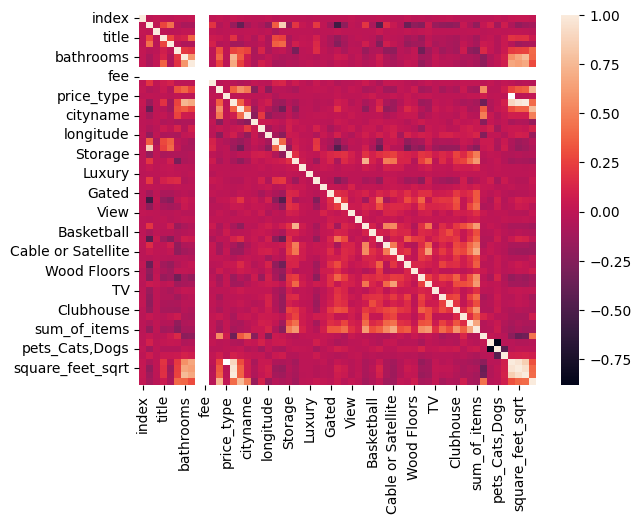

In [129]:
sns.heatmap(corr_matrix)

In [130]:
corr_matrix

,index,id,category,title,body,amenities,bathrooms,bedrooms,currency,fee,...,Patio/Deck,sum_of_items,price_per_sqft,pets_Cats,"pets_Cats,Dogs",pets_Dogs,square_feet_log,square_feet_sqrt,square_feet_exp,price_display
index,1.000000,-0.001415,0.018508,0.003606,-0.006549,0.019372,0.011504,0.029311,NaN,NaN,...,-0.014952,-0.016717,-0.007189,-0.008130,0.010080,-0.005956,0.024814,0.030406,0.030700,0.018929
id,-0.001415,1.000000,0.003973,0.270046,0.433951,-0.029192,-0.090207,-0.085597,NaN,NaN,...,-0.067865,-0.187651,0.023613,0.096330,-0.118874,0.069393,-0.070639,-0.188606,-0.134990,-0.105514
category,0.018508,0.003973,1.000000,-0.004170,-0.021626,-0.013912,0.009846,0.014490,NaN,NaN,...,0.002788,0.005637,-0.017997,-0.003430,0.003893,-0.001752,0.002146,0.006203,-0.001181,-0.017767
title,0.003606,0.270046,-0.004170,1.000000,0.266188,0.082852,0.111003,0.379615,NaN,NaN,...,-0.049158,-0.124170,-0.003240,0.022536,-0.044246,0.050990,0.197721,0.171317,0.183397,0.057173
body,-0.006549,0.433951,-0.021626,0.266188,1.000000,-0.003906,-0.072833,-0.063186,NaN,NaN,...,-0.040611,-0.098638,0.057657,0.031819,-0.050035,0.045694,-0.033446,-0.136911,-0.108855,-0.074306
amenities,0.019372,-0.029192,-0.013912,0.082852,-0.003906,1.000000,0.216203,0.186569,NaN,NaN,...,-0.190725,-0.238016,0.140287,0.025853,-0.047961,0.052579,0.225314,0.246992,0.259448,0.405388
bathrooms,0.011504,-0.090207,0.009846,0.111003,-0.072833,0.216203,1.000000,0.594784,NaN,NaN,...,-0.071436,-0.096252,-0.214261,-0.064822,0.008054,0.105426,0.571855,0.662876,0.760730,0.393329
bedrooms,0.029311,-0.085597,0.014490,0.379615,-0.063186,0.186569,0.594784,1.000000,NaN,NaN,...,-0.054857,-0.096731,-0.199570,-0.044736,0.002676,0.078854,0.664766,0.628993,0.683550,0.291880
currency,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fee,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [131]:
corr_matrix['price_display'].sort_values(ascending=False)

price_display         1.000000
address               0.766636
price                 0.732887
cityname              0.497106
price_per_sqft        0.443343
square_feet_exp       0.417500
square_feet           0.415476
amenities             0.405388
square_feet_sqrt      0.399832
bathrooms             0.393329
square_feet_log       0.311779
bedrooms              0.291880
latitude              0.106873
pets_Dogs             0.084871
Elevator              0.077866
Wood Floors           0.068318
Gym                   0.058593
title                 0.057173
Parking               0.038926
View                  0.028873
index                 0.018929
Doorman               0.017498
TV                    0.017222
Hot Tub               0.013484
Washer Dryer          0.013073
price_type            0.009797
Luxury                0.006280
Gated                -0.002067
Golf                 -0.002503
AC                   -0.004166
Alarm                -0.004446
pets_Cats,Dogs       -0.011803
category

### **Feature Extraction**

In [132]:
FeatureExtraction_data=correlation_data.copy()

In [133]:
top_columns=[]

In [134]:
top_columns+=corr_matrix[corr_matrix['price'] >= 0.2]['price'].index.tolist()

In [135]:
top_columns+=corr_matrix[corr_matrix['price'] <= -0.15]['price'].index.tolist()

In [136]:
top_columns

['amenities',
 'bathrooms',
 'bedrooms',
 'price',
 'square_feet',
 'address',
 'cityname',
 'price_per_sqft',
 'square_feet_log',
 'square_feet_sqrt',
 'square_feet_exp',
 'price_display',
 'state',
 'longitude']

In [137]:
models_data=top_columns

In [138]:
FeatureExtraction_data=FeatureExtraction_data[top_columns]

In [139]:
FeatureExtraction_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7711 entries, 0 to 7907
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   amenities         7711 non-null   float64
 1   bathrooms         7711 non-null   float64
 2   bedrooms          7711 non-null   float64
 3   price             7711 non-null   int64  
 4   square_feet       7711 non-null   float64
 5   address           7711 non-null   float64
 6   cityname          7711 non-null   float64
 7   price_per_sqft    7711 non-null   float64
 8   square_feet_log   7711 non-null   float64
 9   square_feet_sqrt  7711 non-null   float64
 10  square_feet_exp   7711 non-null   float64
 11  price_display     7711 non-null   float64
 12  state             7711 non-null   int32  
 13  longitude         7711 non-null   float64
dtypes: float64(12), int32(1), int64(1)
memory usage: 873.5 KB


In [140]:
FeatureExtraction_data=FeatureExtraction_data.drop(columns=["price","price_per_sqft","square_feet_log","square_feet_sqrt","square_feet_exp"],axis=1)

In [141]:
FeatureExtraction_data

,amenities,bathrooms,bedrooms,square_feet,address,cityname,price_display,state,longitude
0,1281.271725,2.0,2.0,0.333333,1331.739847,1228.915903,1194.0,26,-78.7783
1,1309.588275,1.0,1.0,0.322222,1309.636229,1400.555928,1370.0,47,-89.4003
2,1262.667070,1.0,1.0,0.000000,1262.667070,1321.207364,1009.0,9,-82.3656
3,1350.564848,3.0,2.0,1.000000,1351.921483,1689.206955,1695.0,4,-118.2972
4,1350.564848,2.0,2.0,1.000000,1351.921483,1236.620372,1695.0,18,-91.1012
...,...,...,...,...,...,...,...,...,...
7902,1303.940573,1.0,1.0,0.255556,1254.990670,1101.909392,950.0,42,-95.5405
7904,1396.606082,2.0,2.0,0.626667,1331.739847,1457.179540,1695.0,46,-122.0287
7905,1350.564848,1.0,1.0,0.386667,1351.921483,1498.017685,1695.0,46,-122.1507
7906,1457.916749,1.0,2.0,0.431111,1254.990670,1321.207364,950.0,47,-88.4411


In [142]:
FeatureExtraction_data.columns

Index(['amenities', 'bathrooms', 'bedrooms', 'square_feet', 'address',
       'cityname', 'price_display', 'state', 'longitude'],
      dtype='object')

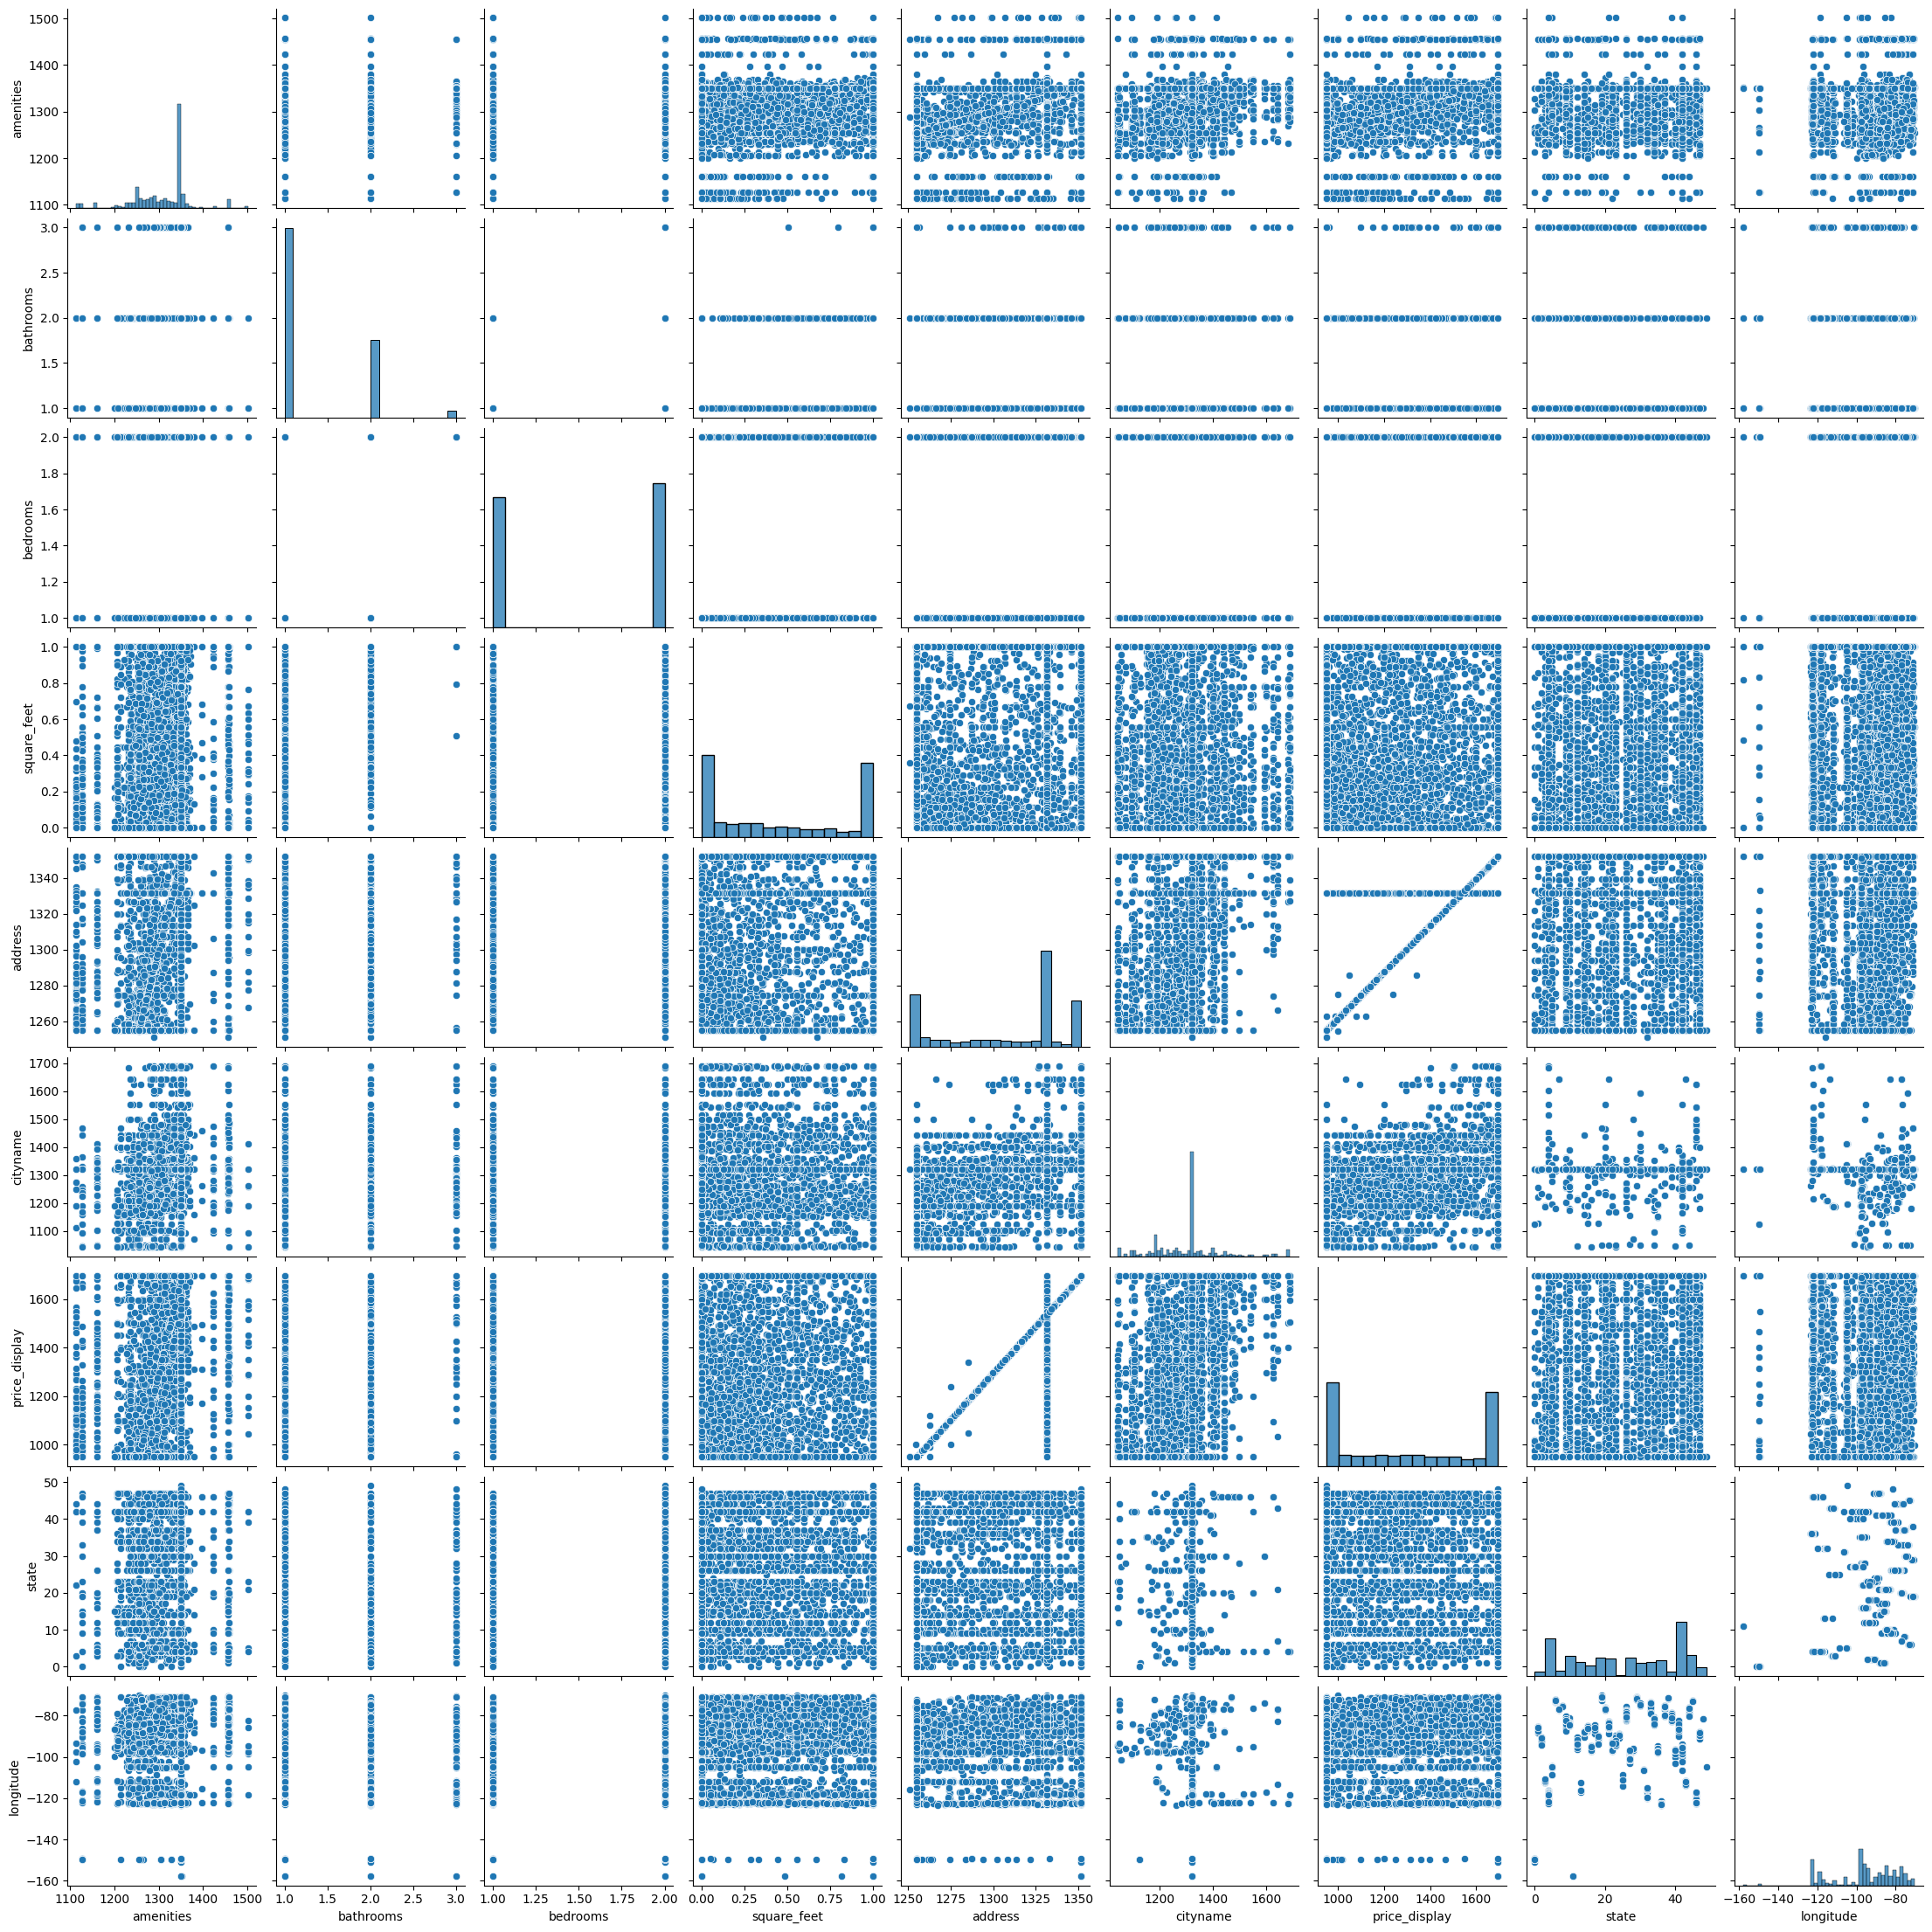

In [143]:
sns.pairplot(FeatureExtraction_data)

In [144]:
FeatureExtraction_data.describe()

,amenities,bathrooms,bedrooms,square_feet,address,cityname,price_display,state,longitude
count,7711.000000,7711.000000,7711.000000,7711.000000,7711.000000,7711.000000,7711.000000,7711.000000,7711.000000
mean,1312.036841,1.331345,1.526521,0.453951,1309.769659,1299.628421,1300.607703,25.996758,-94.644251
std,63.857283,0.520453,0.499329,0.406120,35.723032,125.702050,301.552183,14.913007,15.729027
min,1113.345530,1.000000,1.000000,0.000000,1250.873627,1042.301795,950.000000,0.000000,-157.930500
25%,1270.798850,1.000000,1.000000,0.000000,1269.562819,1209.091391,950.000000,12.000000,-101.301700
50%,1340.345359,1.000000,2.000000,0.355556,1331.739847,1321.207364,1270.000000,26.000000,-93.651600
75%,1350.564848,2.000000,2.000000,1.000000,1331.739847,1321.207364,1685.000000,42.000000,-82.405850
max,1501.586338,3.000000,2.000000,1.000000,1351.921483,1689.206955,1695.000000,49.000000,-70.191600


### **Models**

#### **LinearRegression**

In [192]:
models_data = FeatureExtraction_data.copy()

In [193]:
lastmodels={}

In [194]:
X = models_data.drop(columns=["price_display"])
Y = models_data['price_display'] 

In [195]:
scaler = StandardScaler()
datascaler=scaler.fit(X)
X = datascaler.transform(X)

In [149]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3,random_state=30)


In [150]:
reg = LinearRegression()
lastmodels["linear_regression"]=reg.fit(X_train, y_train)


In [151]:
y_predict=lastmodels["linear_regression"].predict(X_test)

In [152]:
y_train_predict=reg.predict(X_train)

In [153]:
print("train Mean squared error: %.2f" % mean_squared_error(y_train, y_train_predict))
print('train r2_score',r2_score(y_train,y_train_predict))
print("test Mean squared error: %.2f" % mean_squared_error(y_test, y_predict))
print('test r2_score',r2_score(y_test,y_predict))

train Mean squared error: 29353.49
train r2_score 0.6786430271082176
test Mean squared error: 30522.67
test r2_score 0.6598367012135877


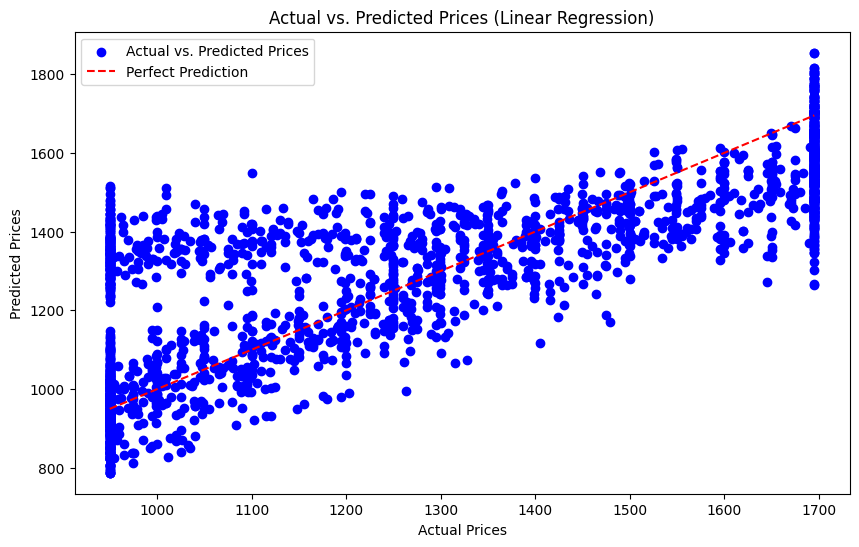

In [154]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_predict, color='blue', label='Actual vs. Predicted Prices')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs. Predicted Prices (Linear Regression)')
plt.legend()
plt.show()

#### **PolynomialFeatures**

In [155]:
polynomialFeatures_data= FeatureExtraction_data.copy()

In [156]:
x = polynomialFeatures_data.drop(columns=["price_display"])
y = polynomialFeatures_data['price_display'] 
scaler = StandardScaler()
x = scaler.fit_transform(x)

In [157]:
degree = 3

In [158]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.30,shuffle=True,random_state=120)

In [159]:
poly_features = PolynomialFeatures(degree=degree)
xfit=poly_features.fit(X_train)
X_poly = xfit.transform(X_train)

In [160]:
model = LinearRegression().fit(X_poly, y_train)
lastmodels["linear_regression_poly"]=model


In [161]:
X_test_poly = poly_features.transform(X_test)
X_train_poly = poly_features.transform(X_train)
y_test_pred = model.predict(X_test_poly)
y_train_predict = model.predict(X_train_poly)

In [162]:
print("train Mean squared error: %.2f" % mean_squared_error(y_train, y_train_predict))
print('train r2_score',r2_score(y_train,y_train_predict))
print("test Mean squared error: %.2f" % mean_squared_error(y_test, y_test_pred))
print('test r2_score',r2_score(y_test,y_test_pred))

train Mean squared error: 17762.23
train r2_score 0.8056040017468022
test Mean squared error: 20700.27
test r2_score 0.7696441564217125


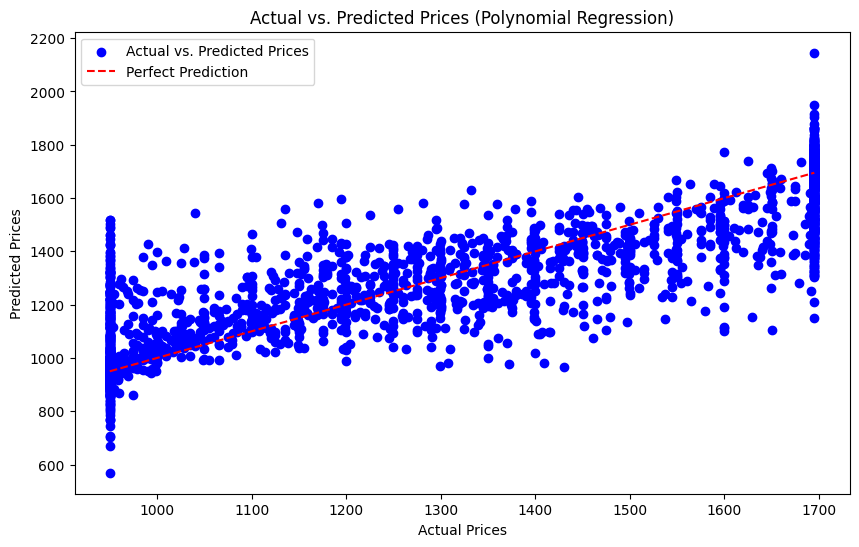

In [163]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, color='blue', label='Actual vs. Predicted Prices')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs. Predicted Prices (Polynomial Regression)')
plt.legend()
plt.show()

#### **RandomForestRegressor**

In [164]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np

# Define features (X) and target variable (y)
X = FeatureExtraction_data.drop(columns=['price_display'])
y = FeatureExtraction_data['price_display']
scaler = StandardScaler()
X = scaler.fit_transform(X)
# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=120)

# Initialize and train the Random Forest Regressor model
model = RandomForestRegressor(n_estimators=4, random_state=42,max_depth=7)
model.fit(X_train, y_train)

lastmodels["random_forest"]=model.fit(X_train, y_train)


# Make predictions on the test set
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("test Mean Squared Error:", mse)
print("test Root Mean Squared Error:", rmse)
print("test R-squared:", r2)

mse = mean_squared_error(y_train, y_train_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_train, y_train_pred)

print("train Mean Squared Error:", mse)
print("train Root Mean Squared Error:", rmse)
print("train R-squared:", r2)

test Mean Squared Error: 13317.027958109247
test Root Mean Squared Error: 115.39942789333597
test R-squared: 0.8518060210975712
train Mean Squared Error: 10992.033836910394
train Root Mean Squared Error: 104.84290074635666
train R-squared: 0.8796993752667608


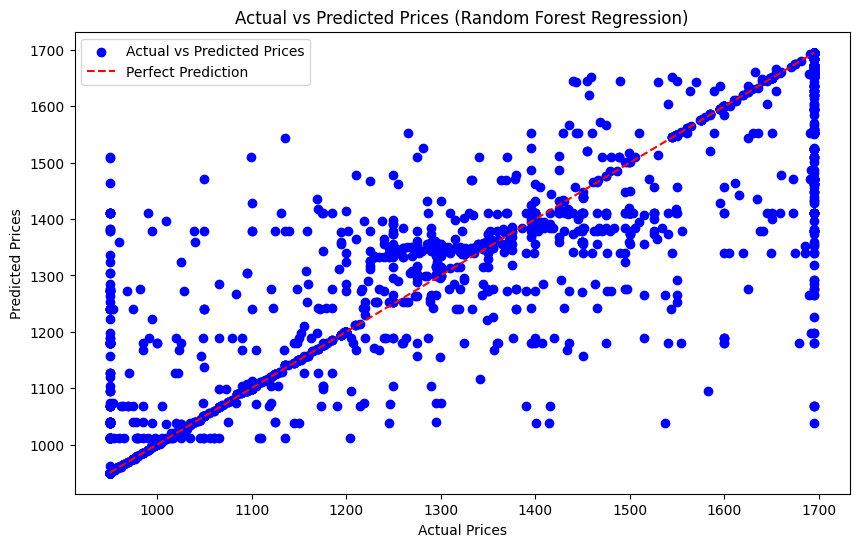

In [165]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', label='Actual vs Predicted Prices')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Prices (Random Forest Regression)')
plt.legend()
plt.show()

#### **GradientBoostingRegressor**

In [166]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np

# Define features (X) and target variable (y)
X = FeatureExtraction_data.drop(columns=['price_display'])
y = FeatureExtraction_data['price_display']
scaler = StandardScaler()
X = scaler.fit_transform(X)
# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize and train the Gradient Boosting Regressor model
model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)

lastmodels["gradient_boosting"]=model.fit(X_train, y_train)


# Make predictions on the test set
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("test Mean Squared Error:", mse)
print("test Root Mean Squared Error:", rmse)
print("test R-squared:", r2)

mse = mean_squared_error(y_train, y_train_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_train, y_train_pred)

print("train Mean Squared Error:", mse)
print("train Root Mean Squared Error:", rmse)
print("train R-squared:", r2)

test Mean Squared Error: 9993.783643674997
test Root Mean Squared Error: 99.96891338648729
test R-squared: 0.8901371591486642
train Mean Squared Error: 9627.699898067662
train Root Mean Squared Error: 98.12084334160434
train R-squared: 0.8940865652369537


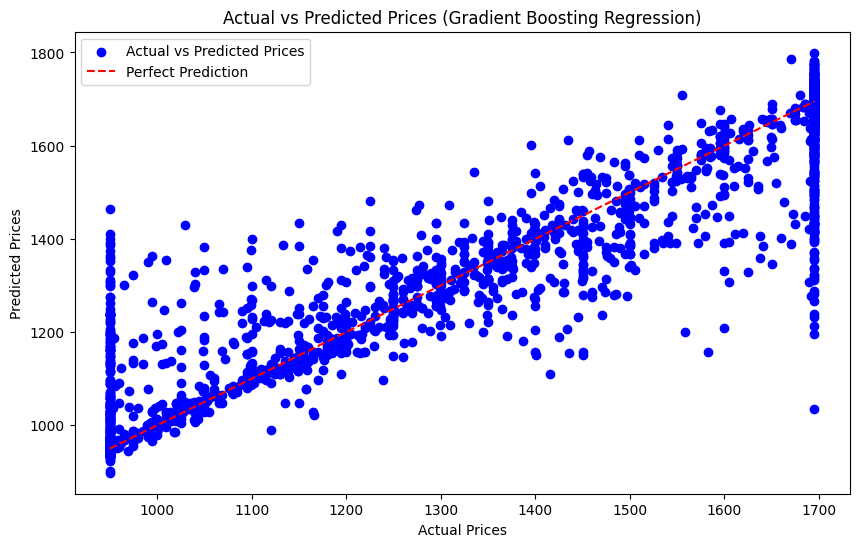

In [167]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', label='Actual vs Predicted Prices')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Prices (Gradient Boosting Regression)')
plt.legend()
plt.show()

#### **StandardScaler**

In [168]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_trian2_scaled = scaler.transform(X_train)
# Initialize the SVR model
svr_model = SVR(kernel='rbf')  # RBF kernel is commonly used, but you can experiment with others

lastmodels["svr"]=svr_model.fit(X_train, y_train)
# Train the model
svr_model.fit(X_train_scaled, y_train)

# Predict on the testing set
y_pred = svr_model.predict(X_test_scaled)
y_train_pred = svr_model.predict(X_trian2_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("test Mean Squared Error:", mse)
print("test Root Mean Squared Error:", rmse)
print("test R-squared:", r2)

mse = mean_squared_error(y_train, y_train_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_train, y_train_pred)

print("train Mean Squared Error:", mse)
print("train Root Mean Squared Error:", rmse)
print("train R-squared:", r2)

test Mean Squared Error: 33229.378584428814
test Root Mean Squared Error: 182.28927172060568
test R-squared: 0.6360421031629218
train Mean Squared Error: 32343.218385014196
train Root Mean Squared Error: 179.84220412632345
train R-squared: 0.6438570466341027


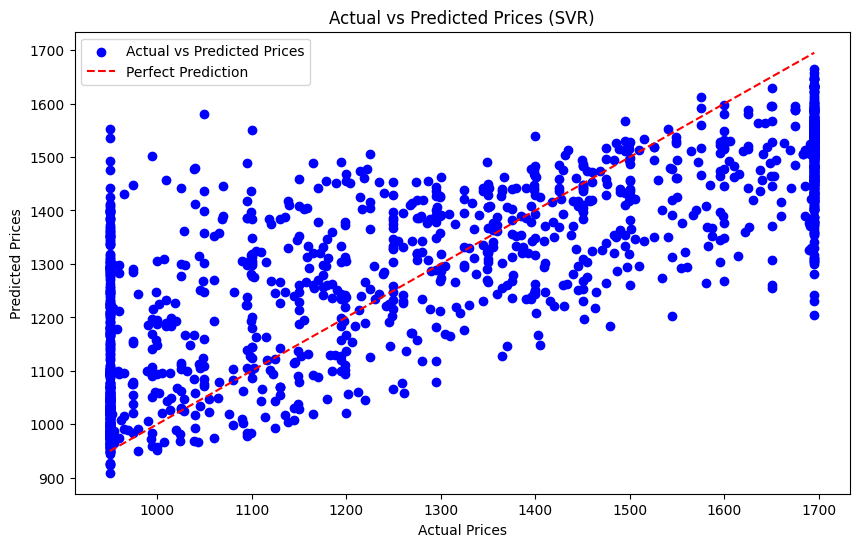

In [169]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', label='Actual vs Predicted Prices')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Prices (SVR)')
plt.legend()
plt.show()

#### **DecisionTreeRegressor**

In [170]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Decision Tree Regression model
tree_model = DecisionTreeRegressor(random_state=42)
lastmodels["decision_tree"]=tree_model.fit(X_train, y_train)

# Train the model
tree_model.fit(X_train, y_train)

# Predict on the testing set
y_pred = tree_model.predict(X_test)
y_train_pred = tree_model.predict(X_train)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("test Mean Squared Error:", mse)
print("test Root Mean Squared Error:", rmse)
print("test R-squared:", r2)

mse = mean_squared_error(y_train, y_train_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_train, y_train_pred)

print("train Mean Squared Error:", mse)
print("train Root Mean Squared Error:", rmse)
print("train R-squared:", r2)

test Mean Squared Error: 15572.978463311008
test Root Mean Squared Error: 124.79174036494166
test R-squared: 0.829430800982485
train Mean Squared Error: 348.82116839602253
train Root Mean Squared Error: 18.67675476082562
train R-squared: 0.9961590031137203


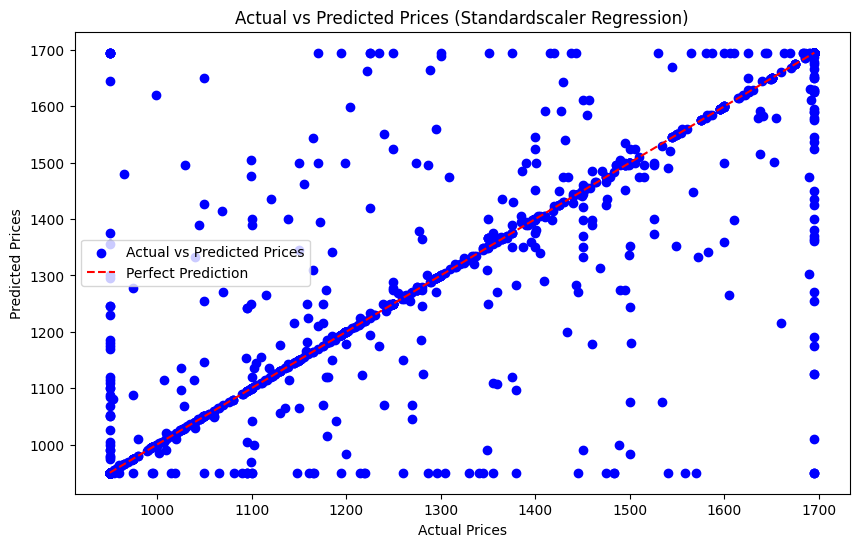

In [171]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', label='Actual vs Predicted Prices')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Prices (Standardscaler Regression)')
plt.legend()
plt.show()

### **Test Script**

In [172]:
columnsweneed =['amenities',
 'bathrooms',
 'bedrooms',
 'square_feet',
 'address',
 'cityname',
 'price_display',
 'state',
 'longitude']

In [173]:
meanmode=data.copy()
fillingnulls={}

In [174]:
for col in columnsweneed :
    if meanmode[col].dtype=="object" :
        fillingnulls[col]=meanmode[col].mode()[0]
    else :
        fillingnulls[col]=meanmode[col].mean()

In [175]:
fillingnulls

{'amenities': 'Parking',
 'bathrooms': 1.3806119889641335,
 'bedrooms': 1.7449017890654324,
 'square_feet': 946.985375,
 'address': '908 8th SW St',
 'cityname': 'Austin',
 'price_display': '$1,350 ',
 'state': 'TX',
 'longitude': -94.81362531582238}

In [176]:
outliers={}

In [177]:
outliers["square_feet"]={"Q3":square_feet_Q3,"Q1":square_feet_Q1}

In [178]:
outliers["price_display"]={"Q3":price_Q3,"Q1":price_Q1}

In [179]:
outliers["bedrooms"]={"Q3":bedrooms_Q3,"Q1":bedrooms_Q1}

In [180]:
encodingweneed={}

In [181]:
for col in columnsweneed :
    if col in encoding.keys():
            encodingweneed[col]=encoding[col]

In [182]:
encodingweneed

{'amenities': TargetEncoder(cols=['cityname', 'amenities', 'address']),
 'address': TargetEncoder(cols=['cityname', 'amenities', 'address']),
 'cityname': TargetEncoder(cols=['cityname', 'amenities', 'address']),
 'state': LabelEncoder()}

In [183]:
lastmodels

{'linear_regression': LinearRegression(),
 'linear_regression_poly': LinearRegression(),
 'random_forest': RandomForestRegressor(max_depth=7, n_estimators=4, random_state=42),
 'gradient_boosting': GradientBoostingRegressor(random_state=42),
 'svr': SVR(),
 'decision_tree': DecisionTreeRegressor(random_state=42)}

In [184]:
variables = {
    "columnsweneed": columnsweneed,
    "fillingnulls": fillingnulls,
    "outliers": outliers,
    "encodingweneed": encodingweneed,
    "square_feet_scaler": square_feet_scaler,
    "lastmodels": lastmodels,
    "citytoremove":citytoremove,
    "xfit":xfit,
    "datascaler":datascaler
}

In [185]:
def predict(data, parameters):
    columnsweneed = parameters["columnsweneed"]
    fillingnulls = parameters["fillingnulls"]
    outliers = parameters["outliers"]
    encodingweneed = parameters["encodingweneed"]
    square_feet_scaler = parameters["square_feet_scaler"]
    lastmodels = parameters["lastmodels"]
    citytoremove=parameters["citytoremove"]
    xfit=parameters["xfit"]
    datascaler=parameters["datascaler"]
    
    df = data[columnsweneed].copy()
    for col in columnsweneed:
        if col != "price_display":
            df[col] = data[col].fillna(fillingnulls[col])

    df["price_display"]=df["price_display"].str.replace("$","")
    df["price_display"]=df["price_display"].str.replace(",","")
    df["price_display"]=df["price_display"].str.replace("Weekly","")
    df["price_display"]=df["price_display"].str.replace("Monthly","")
    df["price_display"]=df["price_display"].str.replace("|","")

    df['bedrooms']=df['bedrooms'].apply(np.floor).astype(float)
    df['bathrooms'] = df['bathrooms'].apply(np.floor).astype(float)

    df.loc[df["cityname"].isin(citytoremove), "cityname"] = "others"

    

    for col in outliers.keys():
        # Convert column to numeric data type if it's not already
        df[col] = pd.to_numeric(df[col], errors='coerce')
        
        # Replace outliers
        Q1 = outliers[col]["Q1"]
        Q3 = outliers[col]["Q3"]
        df[col] = df[col].apply(lambda x: Q3 if x > Q3 else Q1 if x < Q1 else x)

    target=["cityname","amenities","address"]
    df[target] = encodingweneed["amenities"].transform(df[target])
    
    unique_categories = encodingweneed["state"].classes_.astype('object')
    unique_values = df["state"].unique().astype('object')
    combined_categories = np.unique(np.concatenate((unique_categories, unique_values)))
    encodingweneed["state"].fit(combined_categories)
    df["state"] = encodingweneed["state"].transform(df["state"])

    df["square_feet"] = square_feet_scaler.transform(df[["square_feet"]])
    
    X = df.drop(columns=["price_display"], axis=1)
    Y = df["price_display"]
    X=datascaler.transform(X)
    #print(X)
    for model in lastmodels.keys():
        if model == "linear_regression_poly":
            newx = xfit.transform(X)
            r2 = r2_score(Y, lastmodels[model].predict(newx))
            mse = mean_squared_error(Y, lastmodels[model].predict(newx))
            print(f"{model} - R2 Score: {r2}, MSE: {mse}")
        else:
            r2 = r2_score(Y, lastmodels[model].predict(X))
            mse = mean_squared_error(Y, lastmodels[model].predict(X))
            print(f"{model} - R2 Score: {r2}, MSE: {mse}")


In [186]:
with open("model_and_variables.pkl", "wb") as f:
    pickle.dump((variables, predict), f)

In [187]:
with open("model_and_variables.pkl", "rb") as f:
    variabless, predictt = pickle.load(f)

In [188]:
predictt(data, variabless)

linear_regression - R2 Score: 0.6574496141950712, MSE: 31350.78541470176
linear_regression_poly - R2 Score: -2.6118286249261206e+22, MSE: 2.3903893311235096e+27
random_forest - R2 Score: 0.8337567955924587, MSE: 15214.856686809311
gradient_boosting - R2 Score: 0.8616425277770938, MSE: 12662.707741485432
svr - R2 Score: 0.6125274419604407, MSE: 35462.137906046446
decision_tree - R2 Score: 0.9015257540528415, MSE: 9012.528029444446


In [189]:
predictt(sample, variabless)

linear_regression - R2 Score: 0.24614307542934744, MSE: 70856.63529710671
linear_regression_poly - R2 Score: -2.0974352094055139e+21, MSE: 1.97142450839461e+26
random_forest - R2 Score: 0.1339748779673665, MSE: 81399.56566021773
gradient_boosting - R2 Score: 0.2999280806286917, MSE: 65801.26686624241
svr - R2 Score: 0.2887151748239052, MSE: 66855.19202277402
decision_tree - R2 Score: 0.09829770866690668, MSE: 84752.9396111111
